In [1]:
import os
import shutil
import pathlib
import functools 
import re
from spellchecker import SpellChecker
import csv

import pandas as pd
import numpy as np
from PIL import Image
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Data processing and cleaning

In [6]:
def load_metadata(furniture_type):
    df = pd.read_csv('./Bonn_Furniture_Styles_Dataset/metadata/{}.txt'.format(furniture_type), sep="\t", names=['style', 'path', 'nan', 'metadata', 'furniture_type'])
    df.drop(columns=['nan'], inplace=True)
    df.path = df.path.map(lambda x: './Bonn_Furniture_Styles_Dataset/' + x)
    df.furniture_type = furniture_type
    return df
df = functools.reduce(lambda df1, df2: df1.append(df2), list(map(load_metadata, ['beds', 'chairs', 'dressers', 'sofas', 'tables'])))
df.reset_index(inplace=True, drop=True)
df

,style,path,metadata,furniture_type
0,`Eclectic,./Bonn_Furniture_Styles_Dataset/houzz/beds/Ecl...,METADATA: beds;Eclectic,beds
1,Eclectic,./Bonn_Furniture_Styles_Dataset/houzz/beds/Ecl...,METADATA: beds;Eclectic,beds
2,Eclectic,./Bonn_Furniture_Styles_Dataset/houzz/beds/Ecl...,METADATA: beds;Eclectic,beds
3,Eclectic,./Bonn_Furniture_Styles_Dataset/houzz/beds/Ecl...,METADATA: beds;Eclectic,beds
4,Eclectic,./Bonn_Furniture_Styles_Dataset/houzz/beds/Ecl...,METADATA: beds;Eclectic,beds
...,...,...,...,...
57677,Tropical,./Bonn_Furniture_Styles_Dataset/houzz/tables/T...,"METADATA: Miseno;W 0"" / D 0"" / H 0"" / 68 lb.;C...",tables
57678,Tropical,./Bonn_Furniture_Styles_Dataset/houzz/tables/T...,"METADATA: Haussmann Inc.;W 16"" / D 14"" / H 20""...",tables
57679,Tropical,./Bonn_Furniture_Styles_Dataset/houzz/tables/T...,"METADATA: Modway;W 0"" / D 0"" / H 0"" / 0 oz.;nu...",tables
57680,Tropical,./Bonn_Furniture_Styles_Dataset/houzz/tables/T...,METADATA: Tommy Bahama Home Store - Fashion Is...,tables


## Extract furniture subtypes and labels from metadata

In [7]:
def extract_beds_subtype(path):
    result = path.split('.')[1]
    result = result.split('/')[-1]
    result = ''.join([i for i in result if not i.isdigit()])
    result = ' '.join(result.split('-')[1:])
    result = result.replace('style ', '')
    return result

In [8]:
df.loc[df.furniture_type == 'beds', 'metadata'] = df.loc[df.furniture_type == 'beds', 'metadata'].apply(lambda x: ['wood'])
df.loc[df.furniture_type == 'beds', 'furniture_subtype'] = df.loc[df.furniture_type == 'beds', 'path'].apply(extract_beds_subtype)

df.loc[df.furniture_type != 'beds', 'metadata'] = df.loc[df.furniture_type != 'beds', 'metadata'].str.lower().str.split(";")
df.loc[df.furniture_type.isin(['chairs','tables']), 'furniture_subtype'] = df.loc[df.furniture_type.isin(['chairs','dressers','tables']), 'metadata'].apply(lambda x: x[-2])
df = df.drop(df[df['furniture_subtype'].isin(['metadata: tables', 'metadata: chairs', 'products', 'bed', 'beds', 'furniture'])].index)
df.loc[df.furniture_type == 'dressers', 'furniture_subtype'] = ''

df.loc[df.furniture_type != 'beds', 'metadata'] = df.loc[df.furniture_type != 'beds', 'metadata'].apply(lambda x: ' '.join(list(filter(lambda y: y != 'null', x[2:-2]))).split(' '))
df.loc[df.furniture_type != 'beds', 'metadata'] = df.loc[df.furniture_type != 'beds', 'metadata'].apply(lambda x: list(filter(lambda z: z != '', map(lambda y: y.replace('"', '').strip(), x))))
df.loc[df.furniture_type != 'beds', 'metadata'] = df.loc[df.furniture_type != 'beds', 'metadata'].apply(lambda x: [y for y in x if not re.compile('\S*[#|\(|\)|%|$|&|*|+|-|\/|?|=|.|\-|:|\d]\S*').match(y)])
df

,style,path,metadata,furniture_type,furniture_subtype
1,Eclectic,./Bonn_Furniture_Styles_Dataset/houzz/beds/Ecl...,[wood],beds,panel beds
2,Eclectic,./Bonn_Furniture_Styles_Dataset/houzz/beds/Ecl...,[wood],beds,panel beds
3,Eclectic,./Bonn_Furniture_Styles_Dataset/houzz/beds/Ecl...,[wood],beds,bunk beds
4,Eclectic,./Bonn_Furniture_Styles_Dataset/houzz/beds/Ecl...,[wood],beds,kids beds
5,Eclectic,./Bonn_Furniture_Styles_Dataset/houzz/beds/Ecl...,[wood],beds,kids beds
...,...,...,...,...,...
57677,Tropical,./Bonn_Furniture_Styles_Dataset/houzz/tables/T...,"[chestnut, brown, wicker, polyethylene, wicker]",tables,outdoor pub and bistro tables
57678,Tropical,./Bonn_Furniture_Styles_Dataset/houzz/tables/T...,"[brown, sustainable, monkey, pod, wood]",tables,side tables and end tables
57679,Tropical,./Bonn_Furniture_Styles_Dataset/houzz/tables/T...,[],tables,outdoor side tables
57680,Tropical,./Bonn_Furniture_Styles_Dataset/houzz/tables/T...,"[wood, glass]",tables,coffee tables


## Correct spelling mistakes

In [ ]:
labels = list(np.unique(np.concatenate(df.metadata)))
print(len(labels))
print(labels[:20])

In [ ]:
spell = SpellChecker()
misspelled = spell.unknown(labels)
correct_spelling = {key: spell.correction(key) for key in misspelled}
correct_spelling

In [ ]:
clean_labels_conversion = {key: correct_spelling[key]  if key in correct_spelling else key for key in labels}
df.metadata.apply(lambda x: [clean_labels_conversion[y] for y in x])
df.metadata

In [ ]:
clean_labels = list(set([clean_labels_conversion[x] for x in clean_labels_conversion]))
clean_labels.sort()
print(len(clean_labels))
clean_labels[:20]

In [ ]:
with open('clean_labels.csv','w') as result_file:
    wr = csv.writer(result_file, dialect='excel')
    for item in clean_labels:
        wr.writerow([item,])

## Manually edit clean labels for conversion, then update the labels accordingly

In [9]:
label_reduce = pd.read_csv('./clean_labels_marked.csv', index_col=0, names=['before', 'after'])
label_reduce['after'] = label_reduce['after'].apply(lambda x: np.NaN if (x == "NaN" or x == "x") else x)
label_reduce = label_reduce.to_dict()['after']
print(len(label_reduce))
label_reduce

2917


{'a': nan,
 'aaron': nan,
 'abacha': nan,
 'aback': nan,
 'abby': nan,
 'abs': 'plastic',
 'abstract': nan,
 'acacia': 'wood',
 'accent': nan,
 'accents': nan,
 'acer': nan,
 'acetate': 'fabric',
 'acid': nan,
 'acorn': 'wood',
 'acres': nan,
 'acrylic': 'plastic',
 'acryliclegs': 'plastic',
 'acrylonitrile': 'plastic',
 'actual': nan,
 'added': nan,
 'addison': nan,
 'aden': nan,
 'adirondack': nan,
 'adler': nan,
 'adobe': 'brown,wood',
 'aegean': 'grey,wood',
 'afrc': nan,
 'africa': nan,
 'african': nan,
 'agate': 'marble',
 'agatha': nan,
 'aged': nan,
 'aggregate': nan,
 'aging': nan,
 'agonized': nan,
 'air': nan,
 'airbase': nan,
 'aircraft': nan,
 'airehyde': nan,
 'airplanes': nan,
 'aka': nan,
 'alabaster': 'marble',
 'alaskan': nan,
 'alba': nan,
 'albania': nan,
 'albert': nan,
 'albumin': nan,
 'alchemy': nan,
 'alder': 'wood',
 'alegre': nan,
 'alex': nan,
 'alfresco': nan,
 'alice': nan,
 'alien': nan,
 'all': nan,
 'alley': nan,
 'alliance': nan,
 'alligator': nan,
 'a

In [11]:
def flatten(A):
    rt = []
    for i in A:
        if isinstance(i,list): rt.extend(flatten(i))
        else: rt.append(i)
    return rt

def handle_reduce_label_convert(label):
    if (label in label_reduce and type(label_reduce[label]) == str):
        target = label_reduce[label]
        if (',' in target):
            return target.split(',')
        else:
            return target
        return ''
    
def reduce_metadata(metadata):
    result = [handle_reduce_label_convert(y) for y in metadata] # convert to labels in label_reduce
    result = flatten(result) # flatten the list
    result = list(filter(None, list(set(result)))) # remove duplicated and empty elements
    return result

df.loc[:,'metadata'] = df['metadata'].apply(reduce_metadata)
df

,style,path,metadata,furniture_type,furniture_subtype
1,Eclectic,./Bonn_Furniture_Styles_Dataset/houzz/beds/Ecl...,[wood],beds,panel beds
2,Eclectic,./Bonn_Furniture_Styles_Dataset/houzz/beds/Ecl...,[wood],beds,panel beds
3,Eclectic,./Bonn_Furniture_Styles_Dataset/houzz/beds/Ecl...,[wood],beds,bunk beds
4,Eclectic,./Bonn_Furniture_Styles_Dataset/houzz/beds/Ecl...,[wood],beds,kids beds
5,Eclectic,./Bonn_Furniture_Styles_Dataset/houzz/beds/Ecl...,[wood],beds,kids beds
...,...,...,...,...,...
57677,Tropical,./Bonn_Furniture_Styles_Dataset/houzz/tables/T...,"[fabric, brown, wood]",tables,outdoor pub and bistro tables
57678,Tropical,./Bonn_Furniture_Styles_Dataset/houzz/tables/T...,"[brown, wood]",tables,side tables and end tables
57679,Tropical,./Bonn_Furniture_Styles_Dataset/houzz/tables/T...,[],tables,outdoor side tables
57680,Tropical,./Bonn_Furniture_Styles_Dataset/houzz/tables/T...,"[glass, wood]",tables,coffee tables


In [12]:
reduced_metadata = reduce_metadata(label_reduce)
print(len(reduced_metadata))
reduced_metadata

27


['green',
 'rattan',
 'yellow',
 'concrete',
 'blue',
 'marble',
 'plastic',
 'orange',
 'black',
 'ceramic',
 'silver',
 'foam',
 'floral',
 'leather',
 'fabric',
 'pink',
 'purple',
 'glass',
 'red',
 'gold',
 'grey',
 'rock',
 'white',
 'brown',
 'metal',
 'beige',
 'wood']

In [13]:
final_labels = reduced_metadata + list(np.unique(df.furniture_type)) + list(np.unique(df.furniture_subtype.dropna()))
print(len(final_labels))
final_labels

119


['green',
 'rattan',
 'yellow',
 'concrete',
 'blue',
 'marble',
 'plastic',
 'orange',
 'black',
 'ceramic',
 'silver',
 'foam',
 'floral',
 'leather',
 'fabric',
 'pink',
 'purple',
 'glass',
 'red',
 'gold',
 'grey',
 'rock',
 'white',
 'brown',
 'metal',
 'beige',
 'wood',
 'beds',
 'chairs',
 'dressers',
 'sofas',
 'tables',
 '',
 'accent and garden stools',
 'accent chests and cabinets',
 'adirondack chairs',
 'adjustable beds',
 'armchairs and accent chairs',
 'bar stools and counter stools',
 'bathroom cabinets and shelves',
 'bedroom & makeup vanities',
 'bedroom furniture',
 'bedroom furniture sets',
 'buffets and sideboards',
 'bunk beds',
 'cabinet and drawer knobs',
 'canopy beds',
 'changing tables',
 'coffee and accent tables',
 'coffee tables',
 'comforters and comforter sets',
 'console tables',
 'cribs',
 'daybeds',
 'decorative pillows',
 'desks and hutches',
 'dining chairs',
 'dining tables',
 'drafting tables',
 'dresser valets and organizers',
 'dressers',
 'ente

In [14]:
df['label'] = df.apply(lambda x: list(filter(None, x.metadata + [x.furniture_type] + [x.furniture_subtype])), axis=1)
df['label_onehot'] = df.label.apply(lambda x: np.array([1. if y in x else 0. for y in final_labels]))
df

,style,path,metadata,furniture_type,furniture_subtype,label,label_onehot
1,Eclectic,./Bonn_Furniture_Styles_Dataset/houzz/beds/Ecl...,[wood],beds,panel beds,"[wood, beds, panel beds]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Eclectic,./Bonn_Furniture_Styles_Dataset/houzz/beds/Ecl...,[wood],beds,panel beds,"[wood, beds, panel beds]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Eclectic,./Bonn_Furniture_Styles_Dataset/houzz/beds/Ecl...,[wood],beds,bunk beds,"[wood, beds, bunk beds]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Eclectic,./Bonn_Furniture_Styles_Dataset/houzz/beds/Ecl...,[wood],beds,kids beds,"[wood, beds, kids beds]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,Eclectic,./Bonn_Furniture_Styles_Dataset/houzz/beds/Ecl...,[wood],beds,kids beds,"[wood, beds, kids beds]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...
57677,Tropical,./Bonn_Furniture_Styles_Dataset/houzz/tables/T...,"[fabric, brown, wood]",tables,outdoor pub and bistro tables,"[fabric, brown, wood, tables, outdoor pub and ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
57678,Tropical,./Bonn_Furniture_Styles_Dataset/houzz/tables/T...,"[brown, wood]",tables,side tables and end tables,"[brown, wood, tables, side tables and end tables]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
57679,Tropical,./Bonn_Furniture_Styles_Dataset/houzz/tables/T...,[],tables,outdoor side tables,"[tables, outdoor side tables]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
57680,Tropical,./Bonn_Furniture_Styles_Dataset/houzz/tables/T...,"[glass, wood]",tables,coffee tables,"[glass, wood, tables, coffee tables]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


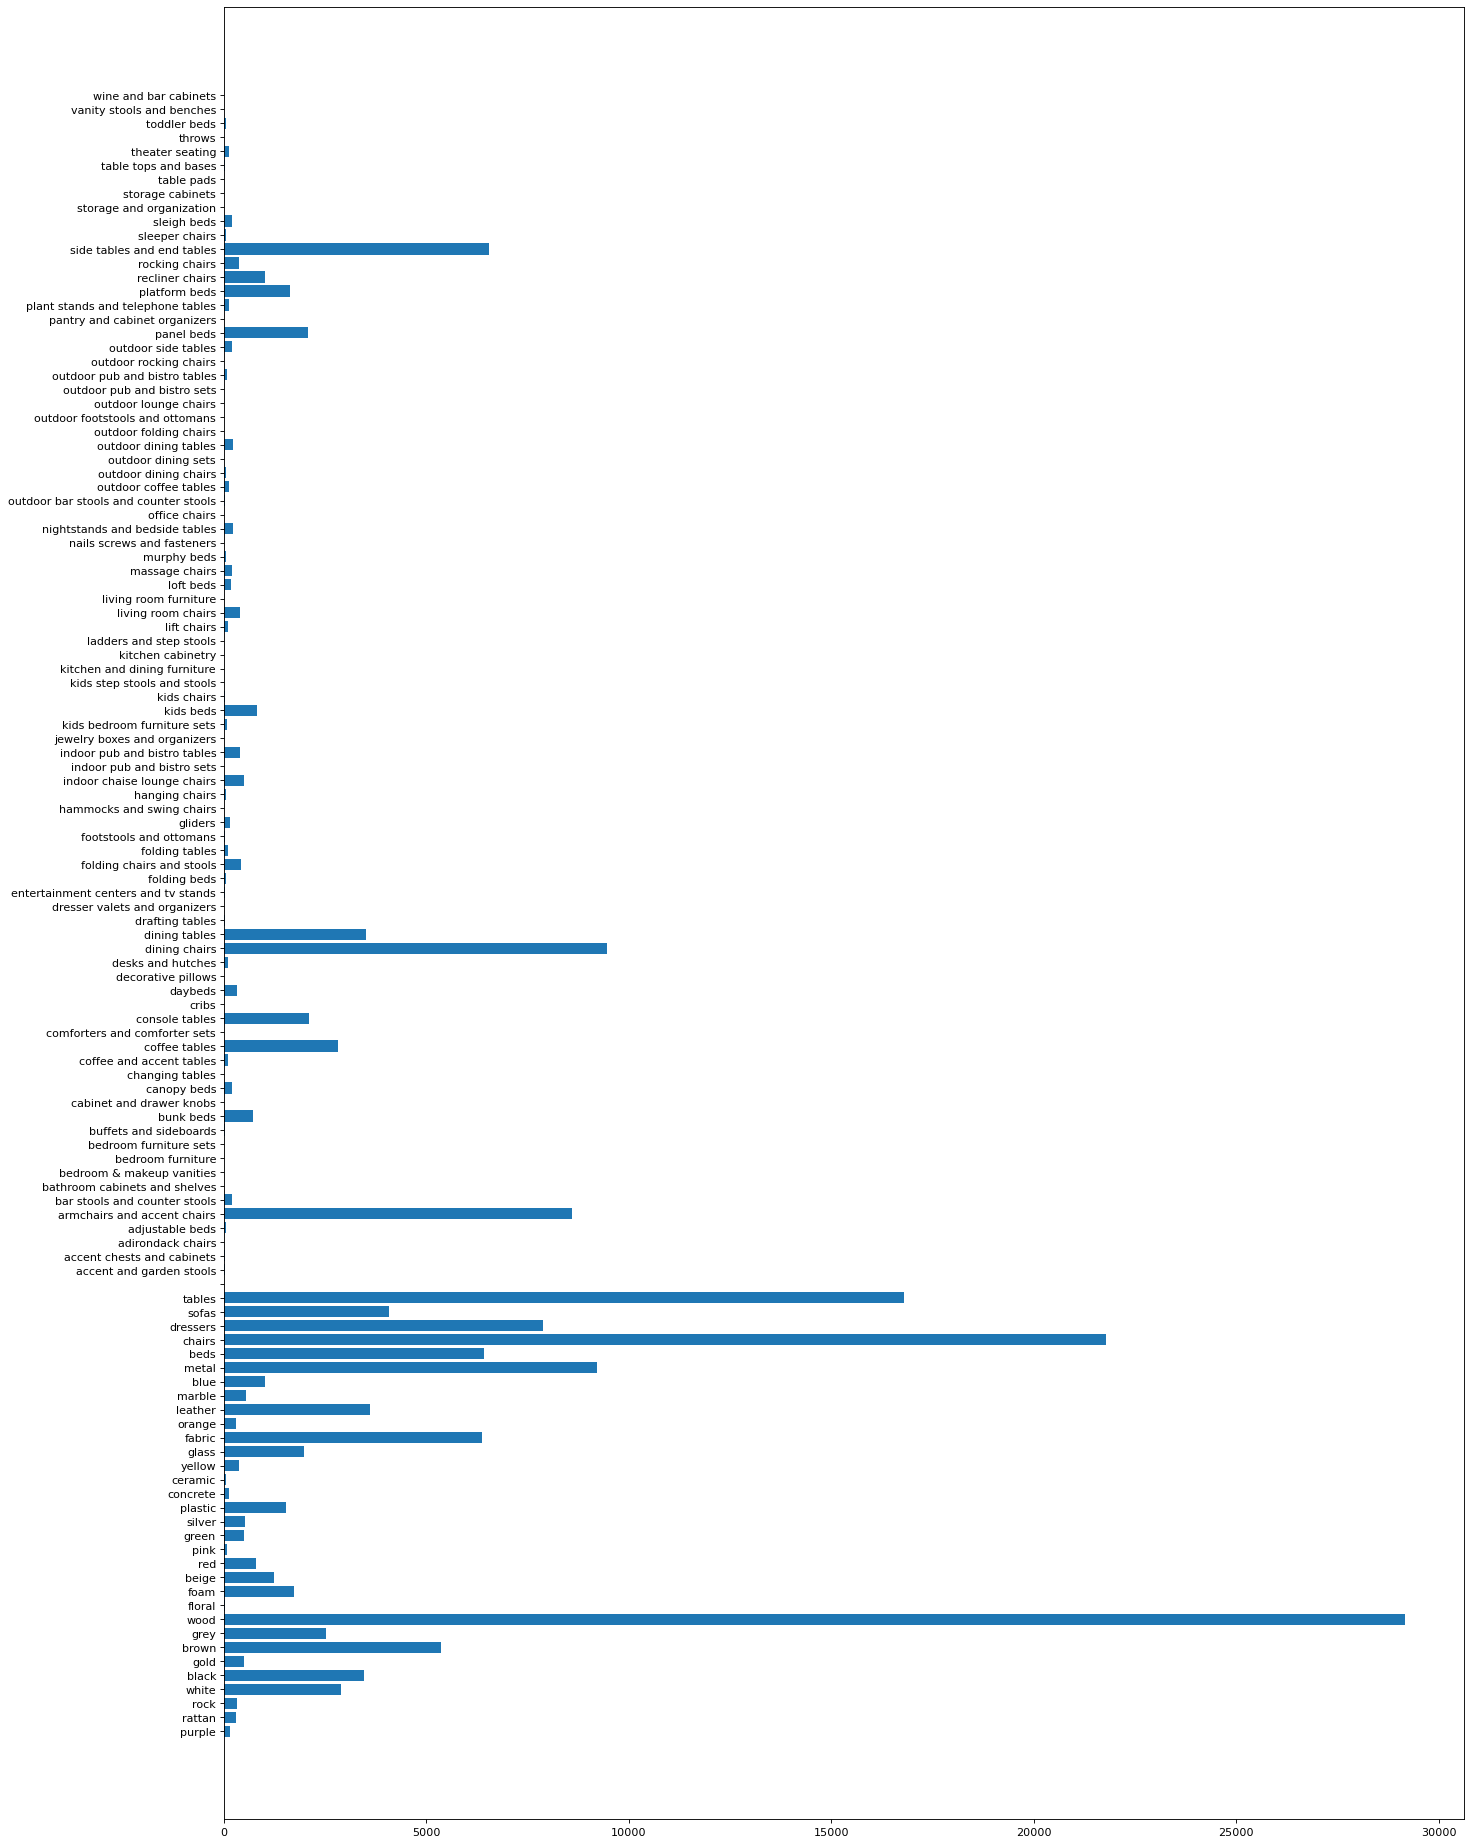

In [72]:
plt.figure(num=None, figsize=(20,30), dpi=80)
plt.barh(final_labels, np.add.reduce(np.array(df['label_onehot'])))
plt.savefig('label_dist.png')

In [73]:
pd.set_option('display.max_columns', 124)
label_distribution = pd.DataFrame(data={'label': final_labels, 'count': np.add.reduce(np.array(df['label_onehot']))}).sort_values(by=['count'])
label_distribution.T
# pd.set_option('display.max_rows', 10)

,32,40,41,42,50,54,67,70,72,39,59,92,102,111,115,79,76,78,86,97,99,52,110,47,112,118,88,45,35,95,77,117,82,94,96,75,89,43,34,61,58,9,33,65,113,68,36,62,91,108,116,85,18,13,98,73,64,48,80,55,90,114,17,103,0,66,83,84,100,38,46,109,93,87,1,22,53,2,106,19,81,71,63,14,69,5,15,24,44,12,74,105,25,11,16,104,10,20,101,51,7,49,3,4,57,23,30,6,21,27,107,29,60,37,26,56,31,28,8
label,,bedroom & makeup vanities,bedroom furniture,bedroom furniture sets,comforters and comforter sets,decorative pillows,hammocks and swing chairs,indoor pub and bistro sets,jewelry boxes and organizers,bathroom cabinets and shelves,dresser valets and organizers,outdoor dining sets,pantry and cabinet organizers,storage cabinets,throws,ladders and step stools,kids step stools and stools,kitchen cabinetry,nails screws and fasteners,outdoor pub and bistro sets,outdoor rocking chairs,cribs,storage and organization,changing tables,table pads,wine and bar cabinets,office chairs,cabinet and drawer knobs,adirondack chairs,outdoor footstools and ottomans,kitchen and dining furniture,vanity stools and benches,living room furniture,outdoor folding chairs,outdoor lounge chairs,kids chairs,outdoor bar stools and counter stools,buffets and sideboards,accent chests and cabinets,entertainment centers and tv stands,drafting tables,floral,accent and garden stools,footstools and ottomans,table tops and bases,hanging chairs,adjustable beds,folding beds,outdoor dining chairs,sleeper chairs,toddler beds,murphy beds,ceramic,pink,outdoor pub and bistro tables,kids bedroom furniture sets,folding tables,coffee and accent tables,lift chairs,desks and hutches,outdoor coffee tables,theater seating,concrete,plant stands and telephone tables,purple,gliders,loft beds,massage chairs,outdoor side tables,bar stools and counter stools,canopy beds,sleigh beds,outdoor dining tables,nightstands and bedside tables,rattan,orange,daybeds,rock,rocking chairs,yellow,living room chairs,indoor pub and bistro tables,folding chairs and stools,green,indoor chaise lounge chairs,gold,silver,marble,bunk beds,red,kids beds,recliner chairs,blue,beige,plastic,platform beds,foam,glass,panel beds,console tables,grey,coffee tables,white,black,dining tables,leather,sofas,brown,fabric,beds,side tables and end tables,dressers,dressers,armchairs and accent chairs,metal,dining chairs,tables,chairs,wood
count,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,3,3,3,4,5,5,5,6,6,8,9,12,14,15,17,18,20,21,22,28,28,29,36,41,48,48,49,60,61,61,64,70,76,87,91,96,103,111,117,128,135,136,142,162,175,189,190,191,194,203,213,230,290,310,317,324,363,377,392,396,421,485,490,496,514,550,709,783,811,1003,1004,1234,1526,1633,1739,1986,2074,2095,2512,2828,2884,3450,3507,3597,4080,5369,6381,6431,6539,7874,7874,8588,9218,9460,16784,21790,29165


In [74]:
label_distribution.to_csv('label_distribution.csv', index=False) 

## From the histogram plot, it's clear that there are labels with very low frequencies. We thus reassign these to other labels, where possible. Otherwise, remove the labels together with the examples

In [15]:
label_dist_reassign = pd.read_csv('label_distribution_reassign.csv')
label_dist_reassign

,label,count,Unnamed: 2
0,hammocks and swing chairs,1,NaN
1,ladders and step stools,1,stools
2,pantry and cabinet organizers,1,NaN
3,outdoor dining sets,1,"dining tables,dining chairs"
4,storage cabinets,1,cabinets
...,...,...,...
114,metal,9218,metal
115,dining chairs,9460,dining chairs
116,tables,16784,tables
117,chairs,21790,chairs


In [16]:
to_remove = label_dist_reassign[label_dist_reassign.isnull().any(axis=1)].loc[:,['label', 'Unnamed: 2']].to_dict()['label']
to_remove = [to_remove[key] for key in to_remove]
to_remove

['hammocks and swing chairs',
 'pantry and cabinet organizers',
 'decorative pillows',
 'dresser valets and organizers',
 'throws',
 'jewelry boxes and organizers',
 'comforters and comforter sets',
 'bedroom & makeup vanities',
 'nails screws and fasteners',
 'cribs',
 'storage and organization',
 'table pads',
 'cabinet and drawer knobs',
 'floral']

In [17]:
df = df.drop(df[df.label.apply(lambda x: bool(list(set(x) & set(to_remove))))].index)
df['label'] = df.label.apply(lambda x: list(filter(None, ['' if (isinstance(obj, float) and obj != obj) else obj for obj in x]))) # remove nan values from labels
df = df.reset_index(drop=True)
df

,style,path,metadata,furniture_type,furniture_subtype,label,label_onehot
0,Eclectic,./Bonn_Furniture_Styles_Dataset/houzz/beds/Ecl...,[wood],beds,panel beds,"[wood, beds, panel beds]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Eclectic,./Bonn_Furniture_Styles_Dataset/houzz/beds/Ecl...,[wood],beds,panel beds,"[wood, beds, panel beds]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Eclectic,./Bonn_Furniture_Styles_Dataset/houzz/beds/Ecl...,[wood],beds,bunk beds,"[wood, beds, bunk beds]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Eclectic,./Bonn_Furniture_Styles_Dataset/houzz/beds/Ecl...,[wood],beds,kids beds,"[wood, beds, kids beds]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Eclectic,./Bonn_Furniture_Styles_Dataset/houzz/beds/Ecl...,[wood],beds,kids beds,"[wood, beds, kids beds]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...
56900,Tropical,./Bonn_Furniture_Styles_Dataset/houzz/tables/T...,"[fabric, brown, wood]",tables,outdoor pub and bistro tables,"[fabric, brown, wood, tables, outdoor pub and ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
56901,Tropical,./Bonn_Furniture_Styles_Dataset/houzz/tables/T...,"[brown, wood]",tables,side tables and end tables,"[brown, wood, tables, side tables and end tables]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
56902,Tropical,./Bonn_Furniture_Styles_Dataset/houzz/tables/T...,[],tables,outdoor side tables,"[tables, outdoor side tables]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
56903,Tropical,./Bonn_Furniture_Styles_Dataset/houzz/tables/T...,"[glass, wood]",tables,coffee tables,"[glass, wood, tables, coffee tables]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [18]:
to_reassign = label_dist_reassign[label_dist_reassign.notna().all(axis=1)].loc[:,['label', 'Unnamed: 2']].set_index('label').to_dict()['Unnamed: 2']
to_reassign

{'ladders and step stools': 'stools',
 'outdoor dining sets': 'dining tables,dining chairs',
 'storage cabinets': 'cabinets',
 'bedroom furniture sets': 'beds',
 'bedroom furniture': 'beds',
 'bathroom cabinets and shelves': 'cabinets',
 'indoor pub and bistro sets': 'pub and bistro tables',
 'kids step stools and stools': 'stools',
 'kitchen cabinetry': 'cabinets',
 'outdoor rocking chairs': 'rocking chairs',
 'outdoor pub and bistro sets': 'pub and bistro tables',
 'changing tables': 'tables',
 'wine and bar cabinets': 'cabinets',
 'office chairs': 'chairs',
 'adirondack chairs': 'chairs',
 'kitchen and dining furniture': 'dining tables,dining chairs',
 'outdoor footstools and ottomans': 'stools',
 'vanity stools and benches': 'folding chairs and stools',
 'living room furniture': 'living room chairs,sofas',
 'outdoor folding chairs': 'folding chairs and stools',
 'outdoor lounge chairs': 'lounge chairs',
 'kids chairs': 'chairs',
 'outdoor bar stools and counter stools': 'folding ch

In [19]:
df['label'] = df['label'].apply(lambda x: flatten([to_reassign[y].split(",") if "," in to_reassign[y] else to_reassign[y] for y in x]))
df

,style,path,metadata,furniture_type,furniture_subtype,label,label_onehot
0,Eclectic,./Bonn_Furniture_Styles_Dataset/houzz/beds/Ecl...,[wood],beds,panel beds,"[wood, beds, panel beds]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Eclectic,./Bonn_Furniture_Styles_Dataset/houzz/beds/Ecl...,[wood],beds,panel beds,"[wood, beds, panel beds]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Eclectic,./Bonn_Furniture_Styles_Dataset/houzz/beds/Ecl...,[wood],beds,bunk beds,"[wood, beds, bunk beds]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Eclectic,./Bonn_Furniture_Styles_Dataset/houzz/beds/Ecl...,[wood],beds,kids beds,"[wood, beds, kids beds]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Eclectic,./Bonn_Furniture_Styles_Dataset/houzz/beds/Ecl...,[wood],beds,kids beds,"[wood, beds, kids beds]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...
56900,Tropical,./Bonn_Furniture_Styles_Dataset/houzz/tables/T...,"[fabric, brown, wood]",tables,outdoor pub and bistro tables,"[fabric, brown, wood, tables, pub and bistro t...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
56901,Tropical,./Bonn_Furniture_Styles_Dataset/houzz/tables/T...,"[brown, wood]",tables,side tables and end tables,"[brown, wood, tables, side tables and end tables]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
56902,Tropical,./Bonn_Furniture_Styles_Dataset/houzz/tables/T...,[],tables,outdoor side tables,"[tables, side tables and end tables]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
56903,Tropical,./Bonn_Furniture_Styles_Dataset/houzz/tables/T...,"[glass, wood]",tables,coffee tables,"[glass, wood, tables, coffee tables]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [20]:
colors = ['brown', 'black', 'white', 'grey', 'beige', 'blue', 'red', 'silver', 'green', 'yellow', 'orange', 'purple', 'pink', 'gold']
print('Number of examples with color label: {}'.format(len(df[df['metadata'].apply(lambda x: bool(list(set(x) & set(colors))))])))
print('Number of all examples: {}'.format(len(df)))

Number of examples with color label: 18148
Number of all examples: 56905


In [21]:
materials = ['wood', 'metal', 'fabric', 'leather', 'glass', 'foam', 'plastic', 'marble', 'rock', 'rattan', 'concrete', 'ceramic']
df_materials = df[df['metadata'].apply(lambda x: bool(list(set(x) & set(materials))))]
print('Number of examples with material label: {}'.format(len(df_materials)))

Number of examples with material label: 39945


## Because of the small number of examples with color labels, we shall train on the sub-dataset with labels for furniture types, subtypes, and materials. The classifier is also trained to recognize these features only.

In [22]:
df_sub = df[df['label'].apply(lambda x: bool(list(set(x) & set(materials))))]
df_sub = df_sub.reset_index(drop=True)
df_sub

,style,path,metadata,furniture_type,furniture_subtype,label,label_onehot
0,Eclectic,./Bonn_Furniture_Styles_Dataset/houzz/beds/Ecl...,[wood],beds,panel beds,"[wood, beds, panel beds]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Eclectic,./Bonn_Furniture_Styles_Dataset/houzz/beds/Ecl...,[wood],beds,panel beds,"[wood, beds, panel beds]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Eclectic,./Bonn_Furniture_Styles_Dataset/houzz/beds/Ecl...,[wood],beds,bunk beds,"[wood, beds, bunk beds]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Eclectic,./Bonn_Furniture_Styles_Dataset/houzz/beds/Ecl...,[wood],beds,kids beds,"[wood, beds, kids beds]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Eclectic,./Bonn_Furniture_Styles_Dataset/houzz/beds/Ecl...,[wood],beds,kids beds,"[wood, beds, kids beds]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...
39940,Tropical,./Bonn_Furniture_Styles_Dataset/houzz/tables/T...,"[brown, wood]",tables,outdoor dining tables,"[brown, wood, tables, dining tables]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
39941,Tropical,./Bonn_Furniture_Styles_Dataset/houzz/tables/T...,"[fabric, brown, wood]",tables,outdoor pub and bistro tables,"[fabric, brown, wood, tables, pub and bistro t...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
39942,Tropical,./Bonn_Furniture_Styles_Dataset/houzz/tables/T...,"[brown, wood]",tables,side tables and end tables,"[brown, wood, tables, side tables and end tables]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
39943,Tropical,./Bonn_Furniture_Styles_Dataset/houzz/tables/T...,"[glass, wood]",tables,coffee tables,"[glass, wood, tables, coffee tables]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [23]:
df_sub['label'] = df_sub['label'] + df_sub['style'].str.lower().str.split(' ')
df_sub['label'] = df_sub['label'].apply(lambda x: list(set(x) - set(colors)))
df_sub

,style,path,metadata,furniture_type,furniture_subtype,label,label_onehot
0,Eclectic,./Bonn_Furniture_Styles_Dataset/houzz/beds/Ecl...,[wood],beds,panel beds,"[panel beds, beds, wood, eclectic]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Eclectic,./Bonn_Furniture_Styles_Dataset/houzz/beds/Ecl...,[wood],beds,panel beds,"[panel beds, beds, wood, eclectic]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Eclectic,./Bonn_Furniture_Styles_Dataset/houzz/beds/Ecl...,[wood],beds,bunk beds,"[bunk beds, wood, beds, eclectic]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Eclectic,./Bonn_Furniture_Styles_Dataset/houzz/beds/Ecl...,[wood],beds,kids beds,"[eclectic, wood, beds, kids beds]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Eclectic,./Bonn_Furniture_Styles_Dataset/houzz/beds/Ecl...,[wood],beds,kids beds,"[eclectic, wood, beds, kids beds]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...
39940,Tropical,./Bonn_Furniture_Styles_Dataset/houzz/tables/T...,"[brown, wood]",tables,outdoor dining tables,"[dining tables, tables, wood, tropical]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
39941,Tropical,./Bonn_Furniture_Styles_Dataset/houzz/tables/T...,"[fabric, brown, wood]",tables,outdoor pub and bistro tables,"[fabric, tables, pub and bistro tables, wood, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
39942,Tropical,./Bonn_Furniture_Styles_Dataset/houzz/tables/T...,"[brown, wood]",tables,side tables and end tables,"[side tables and end tables, tables, wood, tro...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
39943,Tropical,./Bonn_Furniture_Styles_Dataset/houzz/tables/T...,"[glass, wood]",tables,coffee tables,"[glass, tables, wood, coffee tables, tropical]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [24]:
final_labels = list(np.unique(np.concatenate(df_sub.label)))
print(len(final_labels))
final_labels

65


['armchairs and accent chairs',
 'asian',
 'beach',
 'beds',
 'bunk beds',
 'cabinets',
 'canopy beds',
 'ceramic',
 'chairs',
 'coffee and accent tables',
 'coffee tables',
 'concrete',
 'console tables',
 'contemporary',
 'craftsman',
 'daybeds',
 'desks and hutches',
 'dining chairs',
 'dining tables',
 'dressers',
 'eclectic',
 'fabric',
 'farmhouse',
 'foam',
 'folding chairs and stools',
 'folding tables',
 'glass',
 'gliders',
 'industrial',
 'kids beds',
 'leather',
 'lift chairs',
 'living room chairs',
 'loft beds',
 'lounge chairs',
 'marble',
 'massage chairs',
 'mediterranean',
 'metal',
 'midcentury',
 'modern',
 'nightstands and bedside tables',
 'panel beds',
 'plant stands and telephone tables',
 'plastic',
 'platform beds',
 'pub and bistro tables',
 'rattan',
 'recliner chairs',
 'rock',
 'rocking chairs',
 'rustic',
 'scandinavian',
 'side tables and end tables',
 'sleigh beds',
 'sofas',
 'southwestern',
 'stools',
 'tables',
 'theater seating',
 'traditional',
 't

In [25]:
with open('final_labels.txt','w') as f:
  f.write(','.join(final_labels))

In [26]:
df_sub['label_onehot'] = df_sub.label.apply(lambda x: [1. if y in x else 0. for y in final_labels])
df_sub

,style,path,metadata,furniture_type,furniture_subtype,label,label_onehot
0,Eclectic,./Bonn_Furniture_Styles_Dataset/houzz/beds/Ecl...,[wood],beds,panel beds,"[panel beds, beds, wood, eclectic]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Eclectic,./Bonn_Furniture_Styles_Dataset/houzz/beds/Ecl...,[wood],beds,panel beds,"[panel beds, beds, wood, eclectic]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Eclectic,./Bonn_Furniture_Styles_Dataset/houzz/beds/Ecl...,[wood],beds,bunk beds,"[bunk beds, wood, beds, eclectic]","[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Eclectic,./Bonn_Furniture_Styles_Dataset/houzz/beds/Ecl...,[wood],beds,kids beds,"[eclectic, wood, beds, kids beds]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Eclectic,./Bonn_Furniture_Styles_Dataset/houzz/beds/Ecl...,[wood],beds,kids beds,"[eclectic, wood, beds, kids beds]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...
39940,Tropical,./Bonn_Furniture_Styles_Dataset/houzz/tables/T...,"[brown, wood]",tables,outdoor dining tables,"[dining tables, tables, wood, tropical]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
39941,Tropical,./Bonn_Furniture_Styles_Dataset/houzz/tables/T...,"[fabric, brown, wood]",tables,outdoor pub and bistro tables,"[fabric, tables, pub and bistro tables, wood, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
39942,Tropical,./Bonn_Furniture_Styles_Dataset/houzz/tables/T...,"[brown, wood]",tables,side tables and end tables,"[side tables and end tables, tables, wood, tro...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
39943,Tropical,./Bonn_Furniture_Styles_Dataset/houzz/tables/T...,"[glass, wood]",tables,coffee tables,"[glass, tables, wood, coffee tables, tropical]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [49]:
df_sub_count = pd.DataFrame(data={'label': final_labels, 'count': sum(df_sub['label_onehot'].apply(np.array))}).sort_values(by=['count'])
df_sub_count.to_csv('data_with_full_material_labels_summary.csv', index=False)
df_sub_count.T

,5,25,7,16,31,43,27,59,56,11,...,21,3,17,61,60,13,38,58,8,64
label,cabinets,folding tables,ceramic,desks and hutches,lift chairs,plant stands and telephone tables,gliders,theater seating,southwestern,concrete,...,fabric,beds,dining chairs,transitional,traditional,contemporary,metal,tables,chairs,wood
count,47,52,64,74,83,89,91,93,114,135,...,6374,6427,6461,6596,8349,8409,9210,11367,14383,29145


# Model training

In [2]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix

In [3]:
batch_size = 32
epochs = 5

IMG_HEIGHT = 224
IMG_WIDTH = 224

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [4]:
final_labels = []
with open('final_labels.txt','r') as f:
    final_labels = f.read()
final_labels = final_labels.split(',')
N_LABELS = len(final_labels)

In [5]:
df_train = pd.read_csv('data_with_full_material_labels.csv')
df_train['label'] = df_train['label'].apply(lambda x: np.array([float(y) for y in x[1: -1].split(', ')]))
df_train

,path,label
0,./Bonn_Furniture_Styles_Dataset/houzz/beds/Ecl...,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,./Bonn_Furniture_Styles_Dataset/houzz/beds/Ecl...,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,./Bonn_Furniture_Styles_Dataset/houzz/beds/Ecl...,"[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
3,./Bonn_Furniture_Styles_Dataset/houzz/beds/Ecl...,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,./Bonn_Furniture_Styles_Dataset/houzz/beds/Ecl...,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...
39940,./Bonn_Furniture_Styles_Dataset/houzz/tables/T...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
39941,./Bonn_Furniture_Styles_Dataset/houzz/tables/T...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
39942,./Bonn_Furniture_Styles_Dataset/houzz/tables/T...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
39943,./Bonn_Furniture_Styles_Dataset/houzz/tables/T...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [6]:
train, test = train_test_split(df_train, test_size=0.2, random_state=0)
train

,path,label
23730,./Bonn_Furniture_Styles_Dataset/houzz/dressers...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
10908,./Bonn_Furniture_Styles_Dataset/houzz/chairs/T...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
19427,./Bonn_Furniture_Styles_Dataset/houzz/chairs/T...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
36387,./Bonn_Furniture_Styles_Dataset/houzz/tables/A...,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
19856,./Bonn_Furniture_Styles_Dataset/houzz/chairs/T...,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
...,...,...
20757,./Bonn_Furniture_Styles_Dataset/houzz/chairs/M...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
32103,./Bonn_Furniture_Styles_Dataset/houzz/tables/I...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
30403,./Bonn_Furniture_Styles_Dataset/houzz/tables/M...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
21243,./Bonn_Furniture_Styles_Dataset/houzz/dressers...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [7]:
train_ds = tf.data.Dataset.from_tensor_slices((train['path'], np.stack(train['label'])))
val_ds = tf.data.Dataset.from_tensor_slices((test['path'], np.stack(test['label'])))

In [8]:
def import_images(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    return img, tf.convert_to_tensor(label)

In [9]:
train_ds = train_ds.map(import_images)
val_ds = val_ds.map(import_images)

Label:  tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(65,), dtype=float64)


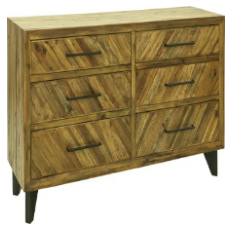

In [10]:
for img, label in train_ds.take(1):
    print('Label: ', label)
    plt.imshow(img.numpy())
    plt.axis('off')

Image shape:  (224, 224, 3)
Label:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


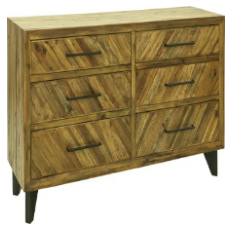

In [11]:
train_ds = train_ds.batch(batch_size).prefetch(AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(AUTOTUNE)

for batch in train_ds.take(1):
    img = batch[0][0]
    label = batch[1][0]
    print("Image shape: ", img.numpy().shape)
    print("Label: ", label.numpy())
    plt.imshow(img.numpy())
    plt.axis('off')

In [12]:
def f1(y, y_hat, thresh=0.5):
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

In [13]:
def accu(y, y_hat, thresh=0.5):
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    tn = tf.cast(tf.math.count_nonzero((1 - y_pred) * (1 - y), axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    acc = (tp + tn) / (tp + tn + fp + fn + 1e-16)
    return tf.reduce_mean(acc)

In [14]:
def prec(y, y_hat, thresh=0.5):
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    prec = tp / (tp + fp + 1e-16)
    return tf.reduce_mean(prec)

In [15]:
def recall(y, y_hat, thresh=0.5):
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    recall = tp / (tp + fn + 1e-16)
    return tf.reduce_mean(recall)

In [16]:
def speci(y, y_hat, thresh=0.5):
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tn = tf.cast(tf.math.count_nonzero((1 - y_pred) * (1 - y), axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    speci = tn / (tn + fp + 1e-16)
    return tf.reduce_mean(speci)

In [17]:
def macro_double_soft_f1(y, y_hat):
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    tn = tf.reduce_sum((1 - y_hat) * (1 - y), axis=0)
    soft_f1_class1 = 2*tp / (2*tp + fn + fp + 1e-16)
    soft_f1_class0 = 2*tn / (2*tn + fn + fp + 1e-16)
    cost_class1 = 1 - soft_f1_class1 # reduce 1 - soft-f1_class1 in order to increase soft-f1 on class 1
    cost_class0 = 1 - soft_f1_class0 # reduce 1 - soft-f1_class0 in order to increase soft-f1 on class 0
    cost = 0.5 * (cost_class1 + cost_class0) # take into account both class 1 and class 0
    macro_cost = tf.reduce_mean(cost) # average on all labels
    return macro_cost

In [18]:
hub_url = "https://tfhub.dev/google/bit/m-r50x1/1"
# feature_extractor_layer = hub.KerasLayer(hub_url, trainable=False)
feature_extractor_layer = hub.KerasLayer(hub_url, trainable=True)

model = tf.keras.Sequential([
    feature_extractor_layer, 
    tf.keras.layers.Dense(N_LABELS, activation='sigmoid', name='output')
])
model.build([None, IMG_HEIGHT, IMG_WIDTH, 3]) 

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  23500352  
_________________________________________________________________
output (Dense)               multiple                  133185    
Total params: 23,633,537
Trainable params: 23,633,537
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
#   loss=tf.keras.losses.BinaryCrossentropy(),
#   optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), // Adam is very slow and 
  loss=macro_double_soft_f1,
  metrics=[prec, recall, f1, accu, speci]
)

In [20]:
weights_path = './multi_labels_weights/weights'
model.load_weights(weights_path)

In [165]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='./multi_labels_weights/weights',
                                                 save_weights_only=True,
                                                 verbose=1)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[cp_callback]
)

Epoch 1/20
999/999 [==============================] - ETA: 0s - loss: 0.3084 - prec: 0.4027 - recall: 0.4075 - f1: 0.3976 - accu: 0.9798 - speci: 0.9850
Epoch 00001: saving model to ./multi_labels_weights/weights
999/999 [==============================] - 954s 955ms/step - loss: 0.3084 - prec: 0.4027 - recall: 0.4075 - f1: 0.3976 - accu: 0.9798 - speci: 0.9850 - val_loss: 0.3458 - val_prec: 0.3341 - val_recall: 0.3449 - val_f1: 0.3294 - val_accu: 0.9692 - val_speci: 0.9782
Epoch 2/20
999/999 [==============================] - ETA: 0s - loss: 0.3067 - prec: 0.4058 - recall: 0.4097 - f1: 0.4005 - accu: 0.9806 - speci: 0.9857
Epoch 00002: saving model to ./multi_labels_weights/weights
999/999 [==============================] - 1022s 1s/step - loss: 0.3067 - prec: 0.4058 - recall: 0.4097 - f1: 0.4005 - accu: 0.9806 - speci: 0.9857 - val_loss: 0.3459 - val_prec: 0.3367 - val_recall: 0.3409 - val_f1: 0.3287 - val_accu: 0.9700 - val_speci: 0.9788
Epoch 3/20
999/999 [==========================

KeyboardInterrupt: 

In [21]:
output = model.predict(val_ds)

In [22]:
y_pred = (output >= 0.5).astype(int)
y_true = np.stack(test['label'])
(y_pred == y_true).mean()

0.9702783635190695

In [48]:
f1(y_pred, y_true).numpy()

0.5142834

In [31]:
import random
test_size = len(test)

Prediction: ['beds', 'rustic', 'tropical', 'wood']
Acutal: ['chairs', 'fabric', 'lounge chairs', 'rustic']


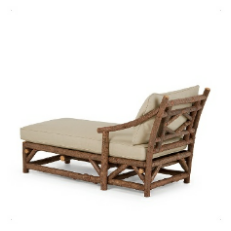

In [64]:
idx = random.randint(0, test_size-1)
path = test.reset_index(drop=True).iloc[idx].path
img = tf.io.read_file(path)
img = tf.image.decode_jpeg(img, channels=3)
img = tf.image.convert_image_dtype(img, tf.float32)
img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
plt.imshow(img.numpy())
plt.axis('off')
print('Prediction: {}'.format(list(filter(None, ['' if y_pred[idx][i] == 0 else x for i, x in enumerate(final_labels)]))))
print('Acutal: {}'.format(list(filter(None, ['' if y_true[idx][i] == 0 else x for i, x in enumerate(final_labels)]))))

In [59]:
final_labels = ['armchairs and accent chairs',
 'asian',
 'beach',
 'beds',
 'bunk beds',
 'cabinets',
 'canopy beds',
 'ceramic',
 'chairs',
 'coffee and accent tables',
 'coffee tables',
 'concrete',
 'console tables',
 'contemporary',
 'craftsman',
 'daybeds',
 'desks and hutches',
 'dining chairs',
 'dining tables',
 'dressers',
 'eclectic',
 'fabric',
 'farmhouse',
 'foam',
 'folding chairs and stools',
 'folding tables',
 'glass',
 'gliders',
 'industrial',
 'kids beds',
 'leather',
 'lift chairs',
 'living room chairs',
 'loft beds',
 'lounge chairs',
 'marble',
 'massage chairs',
 'mediterranean',
 'metal',
 'midcentury',
 'modern',
 'nightstands and bedside tables',
 'panel beds',
 'plant stands and telephone tables',
 'plastic',
 'platform beds',
 'pub and bistro tables',
 'rattan',
 'recliner chairs',
 'rock',
 'rocking chairs',
 'rustic',
 'scandinavian',
 'side tables and end tables',
 'sleigh beds',
 'sofas',
 'southwestern',
 'stools',
 'tables',
 'theater seating',
 'traditional',
 'transitional',
 'tropical',
 'victorian',
 'wood']

Prediction: ['chairs', 'dining chairs', 'midcentury', 'scandinavian', 'wood']
Acutal: ['chairs', 'dining chairs', 'fabric', 'midcentury', 'wood']


In [172]:
print('Prediction: {}'.format(list(filter(None, ['' if y_pred[40][i] == 0 else x for i, x in enumerate(final_labels)]))))
print('Acutal: {}'.format(list(filter(None, ['' if y_true[40][i] == 0 else x for i, x in enumerate(final_labels)]))))

Prediction: ['chairs', 'dining chairs', 'midcentury', 'scandinavian', 'wood']
Acutal: ['chairs', 'dining chairs', 'fabric', 'midcentury', 'wood']


In [40]:
matrix = tfa.metrics.MultiLabelConfusionMatrix(num_classes=N_LABELS)
matrix.update_state(tf.convert_to_tensor(y_true), tf.convert_to_tensor(y_pred))

In [41]:
matrix_np = matrix.result().numpy()

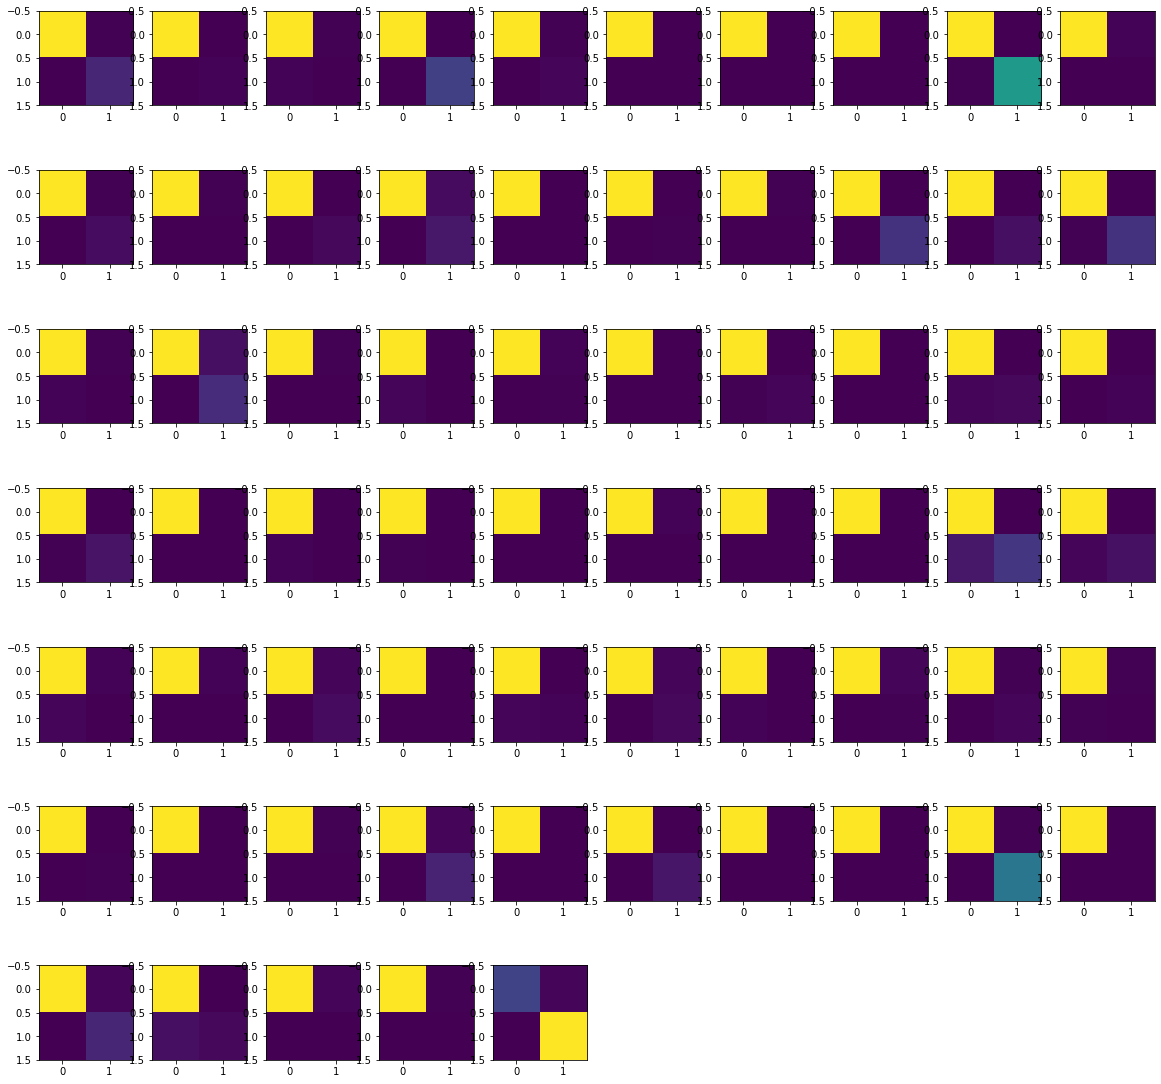

In [42]:
plt.figure(figsize=(20,20))
for i, mtx in enumerate(matrix_np):
    plt.subplot(7, 10, i+1)
    plt.imshow(mtx)
#     plt.xlabel("Predicted")
#     plt.ylabel("True")

In [5]:
model_save_path = './furni_multilabel_saved_model'
tf.saved_model.save(model, model_save_path)

In [5]:
!zip -r furni_multilabel_saved_model.zip furni_multilabel_saved_model

  adding: furni_multilabel_saved_model/ (stored 0%)
  adding: furni_multilabel_saved_model/variables/ (stored 0%)
  adding: furni_multilabel_saved_model/variables/variables.data-00001-of-00002 (deflated 7%)
  adding: furni_multilabel_saved_model/variables/variables.data-00000-of-00002 (deflated 87%)
  adding: furni_multilabel_saved_model/variables/variables.index (deflated 84%)
  adding: furni_multilabel_saved_model/assets/ (stored 0%)
  adding: furni_multilabel_saved_model/saved_model.pb (deflated 92%)


In [1]:
!zip -r furni_multilabel_saved_model.zip furni_multilabel_saved_model

updating: furni_multilabel_saved_model/ (stored 0%)
updating: furni_multilabel_saved_model/variables/ (stored 0%)
updating: furni_multilabel_saved_model/variables/variables.data-00001-of-00002 (deflated 7%)
updating: furni_multilabel_saved_model/variables/variables.data-00000-of-00002 (deflated 87%)
updating: furni_multilabel_saved_model/variables/variables.index (deflated 84%)
updating: furni_multilabel_saved_model/assets/ (stored 0%)
updating: furni_multilabel_saved_model/saved_model.pb (deflated 92%)


In [6]:
loaded = tf.saved_model.load(model_save_path)

In [7]:
print(list(loaded.signatures.keys())) 

['serving_default']


In [8]:
infer = loaded.signatures["serving_default"]

In [9]:
print(infer.structured_outputs)

{'output_1': TensorSpec(shape=(None, 65), dtype=tf.float32, name='output_1')}


In [2]:
final_labels

['armchairs and accent chairs',
 'asian',
 'beach',
 'beds',
 'bunk beds',
 'cabinets',
 'canopy beds',
 'ceramic',
 'chairs',
 'coffee and accent tables',
 'coffee tables',
 'concrete',
 'console tables',
 'contemporary',
 'craftsman',
 'daybeds',
 'desks and hutches',
 'dining chairs',
 'dining tables',
 'dressers',
 'eclectic',
 'fabric',
 'farmhouse',
 'foam',
 'folding chairs and stools',
 'folding tables',
 'glass',
 'gliders',
 'industrial',
 'kids beds',
 'leather',
 'lift chairs',
 'living room chairs',
 'loft beds',
 'lounge chairs',
 'marble',
 'massage chairs',
 'mediterranean',
 'metal',
 'midcentury',
 'modern',
 'nightstands and bedside tables',
 'panel beds',
 'plant stands and telephone tables',
 'plastic',
 'platform beds',
 'pub and bistro tables',
 'rattan',
 'recliner chairs',
 'rock',
 'rocking chairs',
 'rustic',
 'scandinavian',
 'side tables and end tables',
 'sleigh beds',
 'sofas',
 'southwestern',
 'stools',
 'tables',
 'theater seating',
 'traditional',
 't